In [1]:
!pip install monai pydicom gdcm pylibjpeg pylibjpeg-libjpeg
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 62.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.8 MB/s eta 0:00:00:00:01


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-04-09 22:16:08.266355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 22:16:08.266463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 22:16:08.403637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
import cv2

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-04-09 22:16:47.654197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 22:16:47.654253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 22:16:47.655703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [4]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle


from sklearn.model_selection import train_test_split

# Timing utility
from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


In [5]:
# diseases = ['Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']

diseases = ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
# decided on the basis of frequency of occurence of individual diseases in images.

# Drop columns not in the list
columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia', 'image_id']


In [6]:
## From past experiments ##
corrupted_ids = [
    '99905540dca6c8ece8e07ace8362b679',
    'd22b70c6029843ebff15c7e0d0c4b259',
]

In [7]:
# some helper functions:-
def delete_corrupted(df, corrupted_ids):
    df = df[~df['image_id'].isin(corrupted_ids)]
    return df

def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
#     print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def change_dtype(df, To, columns=diseases, root_folder='/train'):
    # Convert data types of specified columns
    for col in columns:
        if col in df.columns:
            try:
                df[col] = df[col].astype(To)
            except ValueError:
                print(f"Unable to convert column '{col}' to data type '{To}'")
    print(f"Changed datatypes of columns of {root_folder.split('/')[-1]} folder")
    return df

def retain_single_disease_examples(df, columns, split='train'):

    filtered_df = df[df[columns].eq(1.0).sum(axis=1) == 1]
    
    print(f"Number of rows removed in {split} to get multiclass classification data:", len(df) - len(filtered_df))
    return filtered_df

    
def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    # Remove rows where all values are 0 in the disease labels
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df
    
    
def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy"))
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df

In [8]:
# Loading the original csv files
train_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_train.csv')
test_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_test.csv')

# delete corrupted images
train_data = delete_corrupted(train_data, corrupted_ids)


disease_labels = list(train_data.columns)[2:]
print("ORIGINAL disease labels:", disease_labels, len(disease_labels))

# Count occurrences of each class
class_counts = train_data.iloc[:, 2:].sum()
print("TOTAL train Individual class counts:-\n", class_counts)
print('-'*100)

class_counts = test_data.iloc[:, 2:].sum()
print("TOTAL test Individual class counts:-\n", class_counts)
print('-'*100)


train_data = change_dtype(train_data, To='int', columns=diseases, root_folder='train')
train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
train_data = retain_single_disease_examples(train_data, diseases, split='train')
train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')
train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/train')
print('-'*100)

test_data = change_dtype(test_data, To='int', columns=diseases, root_folder='test')
test_data = delete_columns(test_data, columns_to_keep=columns_to_keep, root_folder='test')
test_data = retain_single_disease_examples(test_data, diseases, split='test')
test_data = remove_all_zeros(test_data, diseases=diseases, root_folder='test')
test_data = add_file_path_column(test_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/test')
print('-'*100)


# Split 10% of the training data as validation data, with random_state=42, for reproducibility
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# reducing the size (comment this)
# train_data = train_data.head(500)
# val_data = val_data.head(500)
# test_data = test_data.head(500)


# Resetting the index, very important
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)


# collecting & storing the labels separately
train_paths = train_data['file_path'].values
train_labels = train_data[diseases].values

val_paths = val_data['file_path'].values
val_labels = val_data[diseases].values

test_paths = test_data['file_path'].values
test_labels = test_data[diseases].values


print("length of train:", len(train_data))
print("length of val:", len(val_data))
print("length of test:", len(test_data))

ORIGINAL disease labels: ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor'] 15
TOTAL train Individual class counts:-
 No finding                  5141.0
Bronchitis                   842.0
Brocho-pneumonia             545.0
Other disease                412.0
Bronchiolitis                497.0
Situs inversus                11.0
Pneumonia                    392.0
Pleuro-pneumonia               6.0
Diagphramatic hernia           3.0
Tuberculosis                  14.0
Congenital emphysema           2.0
CPAM                           5.0
Hyaline membrane disease      19.0
Mediastinal tumor              8.0
Lung tumor                     5.0
dtype: float64
----------------------------------------------------------------------------------------------------
TOTAL test Individual c

In [9]:
train_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,8e17f30368fdde9f53da6c7f30c99a2d,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,6821bc0bf5bdfd14871c202024b8e3e7,0,0,0,0,0,1,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,ba427884c7e125566c7b135110233f37,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,436f304bafe80d5538b3ff20e166f371,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,9546374ef593de84b449136d4bfb3a11,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [10]:
val_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,e0963255a932923791b1649d0dbe7808,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,28d022ed74a2cafe67c2785f73a9f8eb,0,0,0,1,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,6ff943d2be69df923ef737b042ca321f,0,1,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,c9230ab47911f78f6d88689fb631307f,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,d4d8ae47bf9fcc5fb66cd297a15b32c5,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [11]:
test_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,d7e71a052a753c3f2f3e317d60177bec,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,e64d9421e78c82b5c104021a6c1b4e67,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,8a12a4352a866aaea4691dd27a99c7ae,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,30d6a0843a9792168fdc456c17a9028c,0,0,0,0,0,1,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,f22138be08a24e79cf07f6207341e5f5,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [12]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
#     data = data.astype(np.float32)
#     data = (data * 255.0).astype(np.float32) # no need for this I think 

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Convert image back to float32 in range [0, 1]
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image



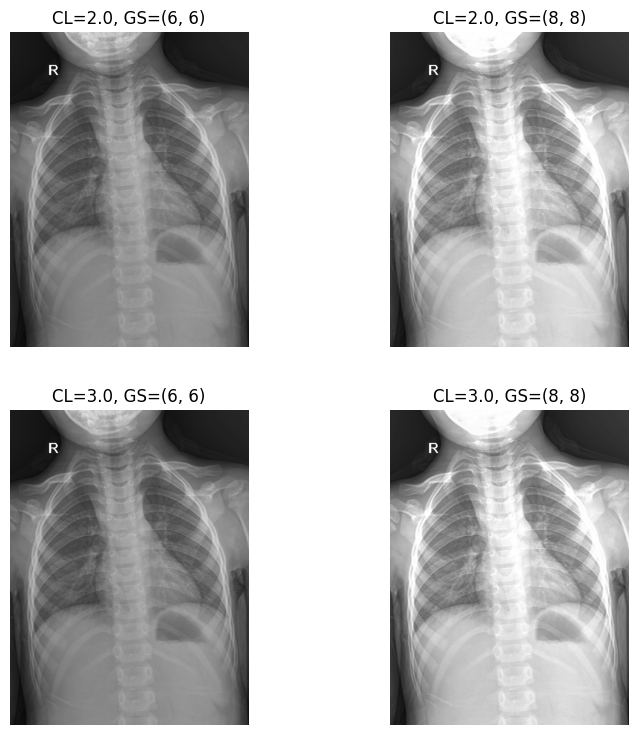

In [13]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/000295d6ff55184f19d99e95f93c3a55.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/002cf1f4cba98648335843f21756ee36.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/0119beca31970c7d5293316a515d7ee9.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/01b9c6193cfd9c247cad1b843a95aca7.dicom'
path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/021405230e5a837a061b9c87f9d2565b.dicom'

clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []

for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

In [14]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files)) 

6713
746
1351


image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)


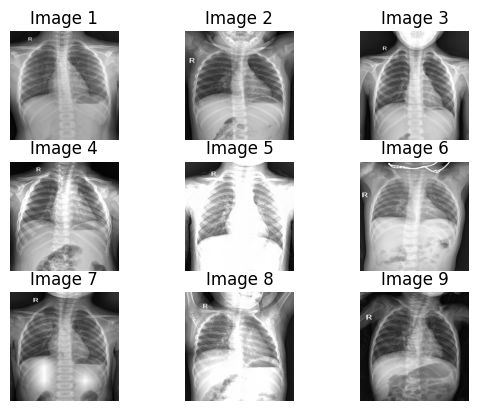

In [15]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_image_files is a list of DICOM file paths
# Example:
# train_image_files = ["path/to/dicom/file1.dcm", "path/to/dicom/file2.dcm", ...]

for i, k in enumerate(np.random.randint(len(train_image_files), size=9)):
#     dicom_image = pydicom.dcmread(train_image_files[k])
    
    # Typecast to float64
#     float64_image_array = dicom_image.pixel_array.astype(np.float64)
    
    float64_image_array = np.load(train_image_files[k])
    print("image_shape:", float64_image_array.shape)
    
    # Visualization using Matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(float64_image_array, cmap='gray')  # Assuming grayscale DICOM images
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [16]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) # the size to which the image would be resized before passing to the model
num_classes = len(diseases) 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes:", num_classes)

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes: 6


In [17]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    # Convert the data to a supported data type (e.g., float32)
    return data.astype(np.float32)


train_transforms = Compose(
    [
#         LoadImage(image_only=True), 
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         RandSpatialCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]), random_size=False),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), # highly sensitive data
#         RandFlip(spatial_axis=0, prob=0.5),  # some abnormalities may be localized in a particular side
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),

        ScaleIntensity(),

    ]
)

# y_pred_trans = Compose([Activations(softmax=True)])
# y_trans = Compose([AsDiscrete(to_onehot=num_class)])

y_pred_trans = Compose([Activations(sigmoid=True)]) # for multi-label classfication
y_trans = Compose([AsDiscrete(threshold_values=True)])


In [18]:
class VINDR_PCXR_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
#         print(index)
        img_path = self.paths[index]
#         print(img_path, index)
        labels = self.labels[index]
#         labels = torch.tensor(labels.values, dtype=torch.long)  # Use dtype=torch.long
        
#         dicom = pydicom.read_file(img_path)
#         image = dicom.pixel_array.astype(np.float32)
#         image = read_xray(img_path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(6,6))
        
        image = np.load(img_path)
    
        # Expand the dimensions to add a channel dimension
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, np.argmax(labels) # return just the index of the disease (instead of the one hot vector)


train_ds = VINDR_PCXR_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_PCXR_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_PCXR_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))


No. of TRAIN batches: 840
No. of VAL batches: 94
No. of TEST batches: 169


In [19]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    #params
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")


    #FLOPS
    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  


    # Move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Use thop.profile to count FLOPs
    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    # Convert FLOPs to gigaFLOPs and format the results
    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")
    

### Model Definition

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

from torch import nn
from timm import create_model


class CoatNetModel(nn.Module):
    def __init__(self, num_classes, fine_tune=False):
        super(CoatNetModel, self).__init__()
        self.coatnet = create_model(
            'timm/coatnet_3_rw_224.sw_in12k', # accepts only 224x224 images
            pretrained=True,
            num_classes=num_classes,
            in_chans=1
        )
        
        if not fine_tune:
            for param in self.coatnet.parameters():
                param.requires_grad = False
            
            for param in self.coatnet.head.parameters():
                param.requires_grad = True
        

    def forward(self, x):
        x = self.coatnet(x)
        return x
    
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoatNetModel(num_classes, fine_tune=False)
model.to(device)

# print(model)
print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output) # logits
display_params_flops(model)

model.safetensors:   0%|          | 0.00/727M [00:00<?, ?B/s]


Model output's shape: torch.Size([1, 6])
tensor([[-0.7358,  1.7112, -0.7665, -0.0276,  1.5399, -2.4704]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 163.64 M
Number of trainable parameters in millions: 0.01 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 32.49G, Params: 163.27M


In [21]:
model = CoatNetModel(num_classes, fine_tune=False) # change fine_tune as required
model.to(device)

loss_function = nn.CrossEntropyLoss() # for multiclass classification

optimizer = torch.optim.Adam(model.parameters(), 3e-5) # adjust learning rate 
# reduce lr during fine tuning

In [22]:
import torch
import torch.nn as nn

# Assuming your model outputs logits
logits = torch.randn(3, num_classes)  # Example logits
targets = torch.randint(0, num_classes, (3,))  # Example targets (multiclass, class indices)
print(logits)
print(targets)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Calculate the loss
loss = criterion(logits, targets.long())
print("loss:", loss)


tensor([[-0.1444, -1.0233, -1.8232, -0.5646, -0.1522,  0.4321],
        [ 0.9575,  0.5613, -1.2500,  0.8654,  0.1977,  0.3553],
        [ 0.1003, -0.6419,  0.1480,  0.7880, -0.1271,  0.5558]])
tensor([4, 4, 0])
loss: tensor(1.8747)


In [23]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=1):
    '''
    returns the 'history' dataframe.
    
    This function trains the model for a fixed number of epochs,
    saving the checkpoints regularly.
    It monitors time taken per epoch and total time elapsed.
    It tracks loss, roc_auc, f1, accuracy, precision, recall for both train & validation data.
    It also saves the best model on loss, roc_auc, f1 and accuracy.
    '''
    
    
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        '''
        It has the following columns:-
        epoch_number, train_loss, val_loss, train_auc, val_auc, train_accuracy, val_accuracy,
        train_f1, val_f1, train_precision, val_precision, train_recall, val_recall,
        time_current_epoch
        '''
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()
#         history = pd.DataFrame(columns=['epoch_number', 'train_loss', 'train_accuracy', 'train_f1',\
#             'train_precision', 'train_recall', 'train_auc', 'train_auc_scores',\
#             'val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_auc','val_auc_scores',\
#             'time_current_epoch'])
        
    # Main loop
    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] # stores the history for the current epoch in a list 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
         # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
#             print("Inside train_loop")
#             print(f"inputs:{inputs.shape}")
#             print(f"labels:{labels} ,{labels.shape}")

            # Clear gradients
            optimizer.zero_grad()

            outputs = model(inputs)
#             print("model outputs:", outputs.shape)
            
            outputs = outputs.float()
            labels = labels.long()

            # Loss and backpropagation of gradients
            loss = loss_function(outputs, labels)
#             print(f"loss: {loss}")

            loss.backward()
            optimizer.step()  # Update the parameters
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            scores = torch.softmax(outputs, dim=1) # to get multiclass probabilites
            _, predictions = torch.max(outputs, 1) # the predicted single class index
            
#             print(f"output probabilites after applying softmax {scores}, {scores.shape}")
#             print(f"predicted class index: {predictions}, {predictions.shape}")
            
            total_train += labels.size(0)  
            correct_train += (predictions == labels).sum().item()
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
            
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
        
#         print("classification report:", classification_report(train_labels_all, train_predictions_all, target_names=diseases))
        
        cm = confusion_matrix(train_labels_all, train_predictions_all) # for multi-class classification
#         print(f"confusion matrix:", cm)

        # Compute accuracy
        accuracy_macro_train = accuracy_score(train_labels_all, train_predictions_all)

        # Compute precision, recall, and F1-score for each class
        precision_arr = precision_score(train_labels_all, train_predictions_all, average=None)
        recall_arr = recall_score(train_labels_all, train_predictions_all, average=None)
        f1_arr = f1_score(train_labels_all, train_predictions_all, average=None)

        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
#         # we will use macro-averaging strategy.
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        
        # Converting labels to one-hot encoding
        lb = LabelBinarizer()
        train_labels_one_hot = lb.fit_transform(train_labels_all)
#         print(f"one hot labels: {train_labels_one_hot}")
#         print(f"actual labels: {train_labels_all}")

        roc_auc_macro_train = round(roc_auc_score(train_labels_one_hot, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        #VALIDATION START:->
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
        
            #Validation loop
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.long()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.softmax(outputs, dim=1) # to get multiclass probabilites
                _, predictions = torch.max(outputs, 1) # the predicted single class index
                total_val += labels.size(0)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)

#             print("classification report:", classification_report(val_labels_all, val_predictions_all, target_names=diseases))

            cm = confusion_matrix(val_labels_all, val_predictions_all) # for multi-class classification
#             print(f"confusion matrix:", cm)

            # Compute accuracy
            accuracy_macro_val = accuracy_score(val_labels_all, val_predictions_all)

            # Compute precision, recall, and F1-score for each class
            precision_arr = precision_score(val_labels_all, val_predictions_all, average=None)
            recall_arr = recall_score(val_labels_all, val_predictions_all, average=None)
            f1_arr = f1_score(val_labels_all, val_predictions_all, average=None)

            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)

    #         # we will use macro-averaging strategy.
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)

            # Convert labels to binary form (one-hot encoding)
            lb = LabelBinarizer()
            val_labels_one_hot = lb.fit_transform(val_labels_all)
    #         print(f"one hot labels: {val_labels_one_hot}")
    #         print(f"actual labels: {val_labels_all}")

            roc_auc_macro_val = round(roc_auc_score(val_labels_one_hot, val_scores_all, average='macro'), 4)
        
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
#         Add values to the history DataFrame
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            # Add other metrics as needed
            'time_current_epoch': time_this_epoch
        })
        
        # Convert the list of dictionaries to a DataFrame
        epoch_history = pd.DataFrame(history_list)

        # Concatenate the new DataFrame with the existing history DataFrame
        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
#         print("history_list:", history_list)
        print('history should be saved')
        
        
#         ### HANDLING THE MODEL SAVING MECHANISM
# #       # Save the model with the best accuracy
        if accuracy_macro_val > valid_max_accuracy:
            valid_max_accuracy = accuracy_macro_val
            best_model_accuracy = model.state_dict()
            torch.save(best_model_accuracy, 'best_model_accuracy.pth')


#         # Save the model with the best AUC
        if roc_auc_macro_val > valid_max_auc:
            valid_max_auc = roc_auc_macro_val
            best_model_auc = model.state_dict()
            torch.save(best_model_auc, 'best_model_auc.pth')


#         # Save the model with the best validation loss
        if val_loss < valid_loss_min:
            valid_loss_min = val_loss
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'best_model_val_loss.pth')
            
        # best precision
        if precision_macro_val > valid_max_precision:
            valid_max_precision = precision_macro_val
            best_model_precision = model.state_dict()
            torch.save(best_model_precision, 'best_model_precision.pth')
        
        # best recall 
        if recall_macro_val > valid_max_recall :
            valid_max_recall  = recall_macro_val
            best_model_recall = model.state_dict()
            torch.save(best_model_recall, 'best_model_recall.pth')
        
        # best f1
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

#         # Saving model every 'save_interval' number of epochs
        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

In [24]:
#  history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=5,
#           ranOnce=False,
#          save_interval=5)

In [28]:
# history

### Fine Tuning

In [28]:
model = CoatNetModel(num_classes, fine_tune=True) # change fine_tune as required
model.to(device)


loss_function = nn.CrossEntropyLoss() # for multiclass classification
optimizer = torch.optim.Adam(model.parameters(), 7e-6) # adjust learning rate 
# reduce lr during fine tuning

In [29]:
# # give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

# history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=95,
#           ranOnce=True, model_path='/kaggle/working/model_5.pth', history_path='/kaggle/working/history.csv',
#          epochs_ran=5, save_interval=10)

In [ ]:
# # give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

# history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=10,
#           ranOnce=True, model_path='/kaggle/input/31-03-2024-vindrpcxr-coatnet-multiclass-weights/model_90.pth', history_path='/kaggle/input/31-03-2024-vindrpcxr-coatnet-multiclass-weights/history.csv',
#          epochs_ran=90, save_interval=10)

Model was already trained fo 90 epochs,    with minimum loss: 0.99376409802031, max accuracy: 0.67828418230563,    max auc: 0.76, max precision: 0.3895,     max recall: 0.2792, max f1: 0.2822


 45%|████▍     | 375/840 [03:15<04:00,  1.93it/s]

### Testing Phase

In [24]:
# set it to '/kaggle/working/history.csv' while running by SAVE and COMMIT
# history_path = '/kaggle/working/history.csv'
history_path = '/kaggle/input/31-03-2024-vindrpcxr-coatnet-multiclass-weights/history.csv'
history = pd.read_csv(history_path)

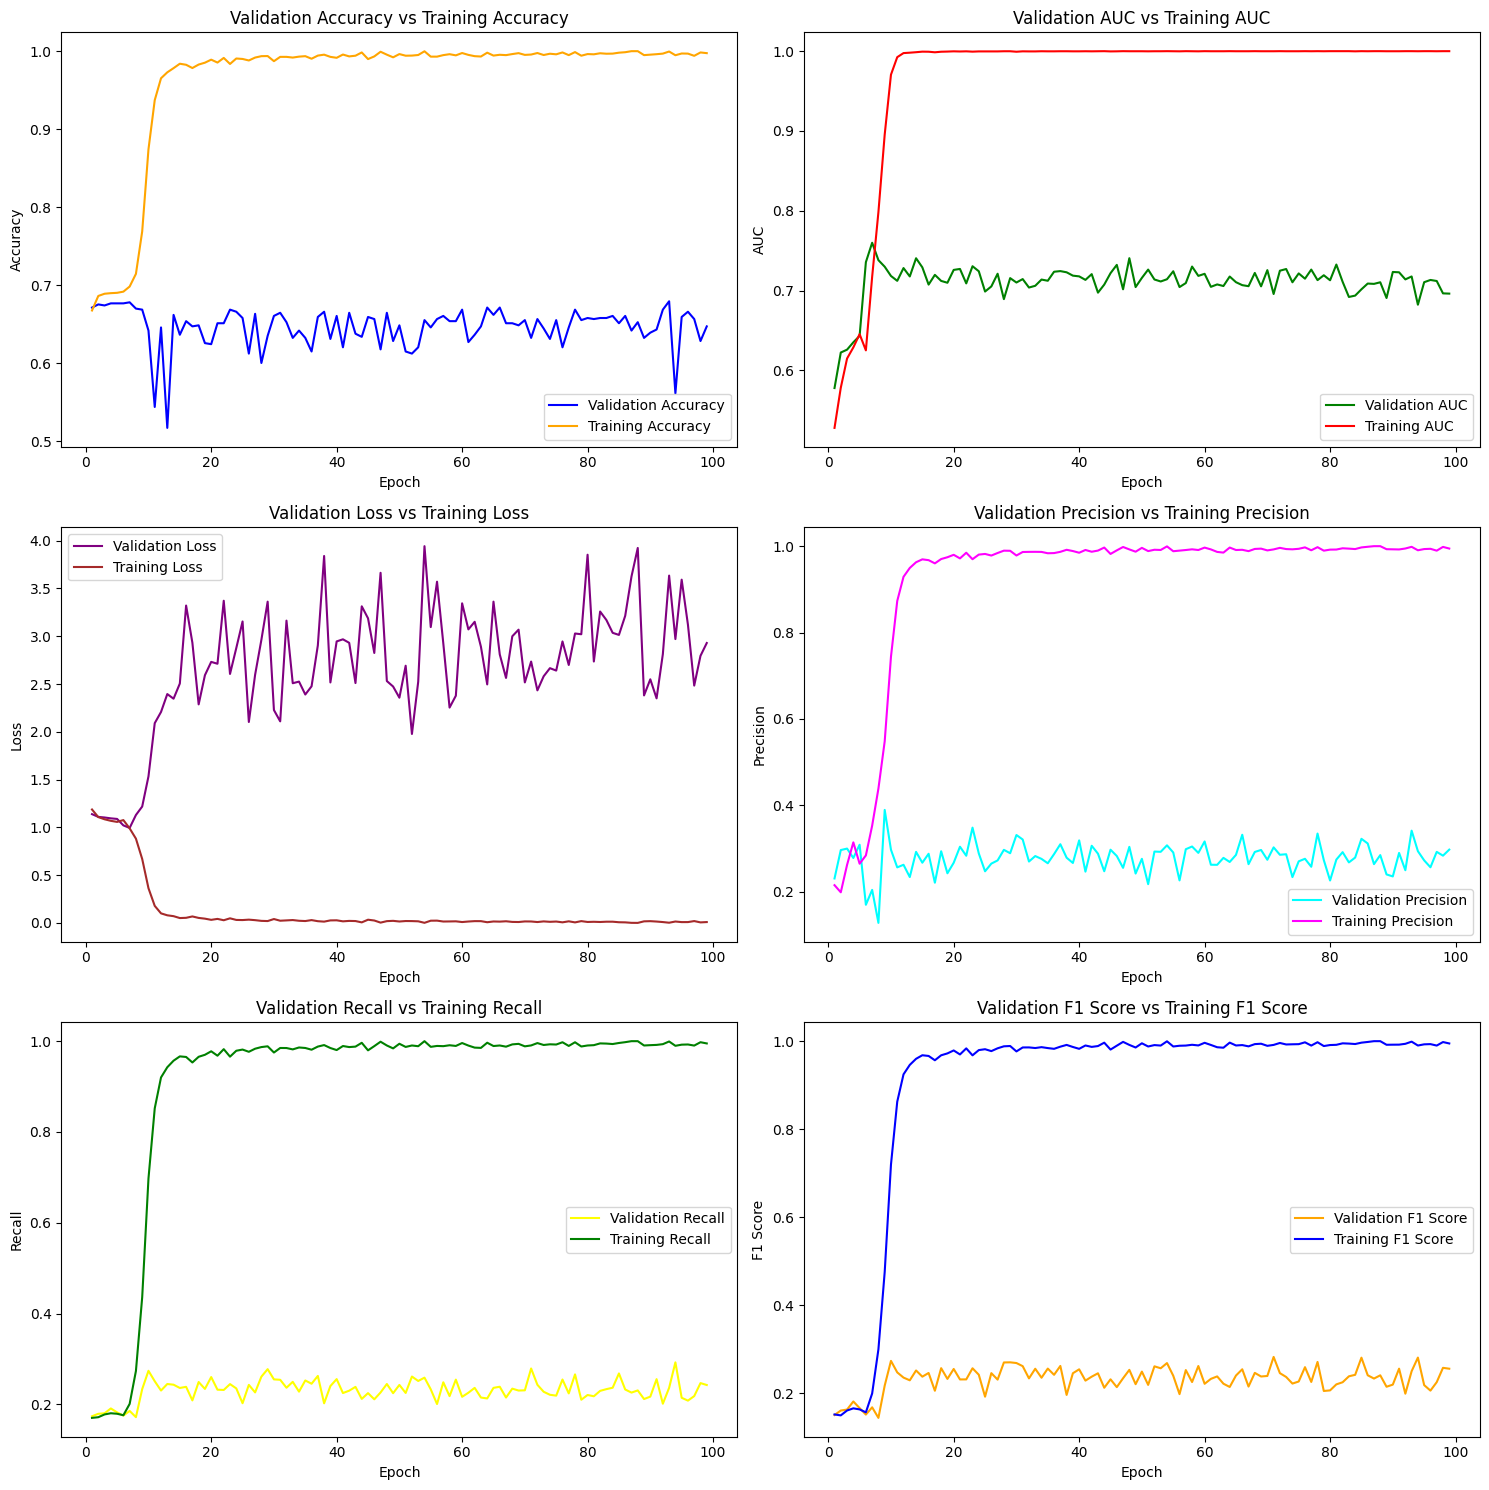

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy
axes[0, 0].plot(history['epoch_number'], history['val_accuracy'], label='Validation Accuracy', color='blue')
axes[0, 0].plot(history['epoch_number'], history['train_accuracy'], label='Training Accuracy', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Training Accuracy')
axes[0, 0].legend()

# Plot AUC
axes[0, 1].plot(history['epoch_number'], history['val_auc'], label='Validation AUC', color='green')
axes[0, 1].plot(history['epoch_number'], history['train_auc'], label='Training AUC', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC vs Training AUC')
axes[0, 1].legend()

# Plot loss
axes[1, 0].plot(history['epoch_number'], history['val_loss'], label='Validation Loss', color='purple')
axes[1, 0].plot(history['epoch_number'], history['train_loss'], label='Training Loss', color='brown')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss vs Training Loss')
axes[1, 0].legend()

# Plot precision
axes[1, 1].plot(history['epoch_number'], history['val_precision'], label='Validation Precision', color='cyan')
axes[1, 1].plot(history['epoch_number'], history['train_precision'], label='Training Precision', color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Validation Precision vs Training Precision')
axes[1, 1].legend()

# Plot recall
axes[2, 0].plot(history['epoch_number'], history['val_recall'], label='Validation Recall', color='yellow')
axes[2, 0].plot(history['epoch_number'], history['train_recall'], label='Training Recall', color='green')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].set_title('Validation Recall vs Training Recall')
axes[2, 0].legend()

# Plot F1 score
axes[2, 1].plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
axes[2, 1].plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].set_title('Validation F1 Score vs Training F1 Score')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# model_path = '/kaggle/working/best_model_precision.pth'
model_path = '/kaggle/input/31-03-2024-vindrpcxr-coatnet-multiclass-weights/best_model_precision.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [27]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


# Don't need to keep track of gradients
with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    start = timer()
    #Test loop
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()


        scores = torch.softmax(outputs, dim=1) # to get multiclass probabilites
        _, predictions = torch.max(outputs, 1) # the predicted single class index
        total_test += labels.size(0)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=diseases)) 
    # adjust the target_names


    cm = confusion_matrix(test_labels_all, test_predictions_all) # for multi-class classification
    print(f"confusion matrix:", cm)

    # Compute accuracy
    accuracy_macro_test = accuracy_score(test_labels_all, test_predictions_all)

    # Compute precision, recall, and F1-score for each class
    precision_arr = precision_score(test_labels_all, test_predictions_all, average=None)
    recall_arr = recall_score(test_labels_all, test_predictions_all, average=None)
    f1_arr = f1_score(test_labels_all, test_predictions_all, average=None)

    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)

    # we will use macro-averaging strategy.
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)

    # Convert labels to binary form (one-hot encoding)
    lb = LabelBinarizer()
    test_labels_one_hot = lb.fit_transform(test_labels_all)
#     print(f"one hot labels: {test_labels_one_hot}")
#     print(f"actual labels: {test_labels_all}")

    roc_auc_macro_test = round(roc_auc_score(test_labels_one_hot, test_scores_all, average='macro'), 4)
        
    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 169/169 [00:23<00:00,  7.30it/s]


Accuracy: 0.6617
correct: 894  out of  1351
                  precision    recall  f1-score   support

      No finding       0.72      0.93      0.82       907
      Bronchitis       0.26      0.13      0.17       155
Brocho-pneumonia       0.38      0.05      0.09        61
   Other disease       0.25      0.04      0.07        70
   Bronchiolitis       0.09      0.01      0.02        81
       Pneumonia       0.28      0.27      0.28        77

        accuracy                           0.66      1351
       macro avg       0.33      0.24      0.24      1351
    weighted avg       0.57      0.66      0.59      1351

confusion matrix: [[846  32   0   8   4  17]
 [119  20   2   0   3  11]
 [ 29  17   3   0   2  10]
 [ 60   2   1   3   0   4]
 [ 66   2   1   0   1  11]
 [ 49   4   1   1   1  21]]
MACRO-averged metrics:- accuracy: 0.6617320503330866, precision: 0.3305, recall: 0.2398, f1: 0.2412, ROC_AUC: 0.7254
INFERENCE TIME: 23.1974 seconds
-------------------------------------------